# GCNConv Model Evaluation

This notebook walks throught the evaluation of a GCN Model utilising GCNConv layers provided by the PyTorch Geometric package.

In [1]:
import pandas as pd
import numpy as np
import torch
import networkx as nx
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from preprocessing.featurisation import get_atom_features, get_bond_features
from preprocessing.fetch_smiles import resolve_smiles_by_cas_interactive
from preprocessing.smiles_to_graph import batch_from_csv


## Importing the data

The first step is to import the data that can be found in the `data/processed` folders.

In [2]:
# Produce SMILES strings from CAS numbers
# df = resolve_smiles_by_cas_interactive("data/raw/Ozkan_data_2024.xlsx", "data/processed/input.csv")

# Convert smiles strings in the CSV file to a list of PyTorch graphs
graph_list = batch_from_csv("data/processed/input.csv")
molecules_df = pd.read_csv("data/processed/input.csv")


In [3]:
num_node_features = graph_list[0].num_node_features
num_edge_features = graph_list[0].num_edge_features
avg_degree = 2*(graph_list[0].num_edges) / graph_list[0].num_nodes
print(f"Number of node features: {num_node_features}")
print(f"Average degree of the graph: {avg_degree:.2f}") # From the avg. degree we can use at least 4 GCNConv layers
print(f"Number of edge features: {num_edge_features}")


Number of node features: 79
Average degree of the graph: 4.00
Number of edge features: 10


(torch.Size([8, 79]), torch.Size([2, 16]))

In [5]:
graph_list[0].y

tensor([5.2900])

The variance of our dataset target values are given by the cell below. The variance is 32.065 - meaning that it has significant spread making our graph-level regression task more difficult for our model.

In [95]:
ys = np.array([data.y.item() for data in graph_list])
variance = np.var(ys)  # Use ddof=1 for sample variance
print("Variance:", variance)

Variance: 32.06530972525442


## Model Training and Prediction Eval Functions

Random seed to ensure reproducibility of results and consistent random weight initialisations.

In [6]:
import torch
import random
import numpy as np

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(123)


Training function for the GCN model - taking batched data.
Followed by the plot predictions function to visualise the accuracy of the predicitons made.

In [ ]:
# TODO: experiment with batch size of 8. 

from torch.nn import MSELoss
from torch_geometric.loader import DataLoader

train_loader = DataLoader(graph_list, batch_size=32, shuffle=True)


def train_gcn_model_batched(dataloader, model, lr=1e-3, epochs=300):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = MSELoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch).squeeze()
            target = batch.y.squeeze()

            assert out.shape == target.shape, f"{out.shape=} vs {target.shape=}"
            loss = loss_fn(out, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    
    return model



In [8]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_predictions(dataloader, model):
    """
    Function to plot predictions vs actual values.
    """
    all_preds = [] 
    all_targets = []

    # Put model in evaluation mode
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            preds = model(batch.x, batch.edge_index, batch.batch).squeeze()
            targets = batch.y.squeeze()

            # Handle possible shape mismatches
            if preds.dim() == 0:
                preds = preds.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Compute metrics
    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"R² score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(all_targets, all_preds, alpha=0.7)
    plt.plot([all_targets.min(), all_targets.max()],
             [all_targets.min(), all_targets.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predicted vs. Actual - GCN Model (Batched)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
import plotly
plotly.__version__

'6.2.0'

In [10]:
molecules_df.head()

,Inhibitor Name,CAS Number,Inh Power,SMILES
0,1-H-imidazole-2-carboxylic acid,16042-25-4,5.29,C1=CN=C(N1)C(=O)O
1,1-methyl-1-H-benzimidazole-2-thiol,2360-22-7,10.04,CN1C2=CC=CC=C2NC1=S
2,1-methyl-benzimidazole,1632-83-3,-0.51,CN1C=NC2=CC=CC=C21
3,"1,2,4-triazole",288-88-0,2.09,C1=NC=NN1
4,"1,3-diisopropyl-2-thiourea",2986-17-6,3.54,CC(C)NC(=S)NC(C)C


In [11]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
import torch

def plot_predictions_plotly(dataloader, model, metadata_df=None):
    """
    Function to plot predictions vs actual values using Plotly with hover tooltips.
    
    metadata_df: Optional DataFrame with molecule metadata.
                 Should have at least as many rows as total predictions.
                 Example columns: MoleculeName, SMILES, CAS.
    """
    all_preds = []
    all_targets = []

    # Put model in eval mode
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            preds = model(batch.x, batch.edge_index, batch.batch).squeeze()
            targets = batch.y.squeeze()

            if preds.dim() == 0:
                preds = preds.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    # Flatten
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Compute metrics
    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"R² score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")

    # Build DataFrame
    df = pd.DataFrame({
        "Actual": all_targets,
        "Predicted": all_preds
    })

    # Merge metadata if available
    if metadata_df is not None:
        metadata_df = metadata_df.reset_index(drop=True)
        df = pd.concat([df, metadata_df.iloc[:len(df)].reset_index(drop=True)], axis=1)

    # Make plot
    fig = px.scatter(
        df,
        x="Actual",
        y="Predicted",
        hover_data={
            "Inhibitor Name": True,
            "Inh Power": False, #':.2f',
            "CAS Number": False,
            "SMILES": False
        },
        title="Predicted vs Actual - GCNModel (Batched)",
        labels={"Actual": "Actual", "Predicted": "Predicted"},
        height=600,
        width=600
    )

    # Identity line y=x
    fig.add_shape(
        type="line",
        x0=df["Actual"].min(),
        y0=df["Actual"].min(),
        x1=df["Actual"].max(),
        y1=df["Actual"].max(),
        line=dict(color="red", dash="dash"),
    )

    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.update_layout(showlegend=False)
    fig.show()



In [12]:
molecules_df.columns

Index(['Inhibitor Name', 'CAS Number', 'Inh Power', 'SMILES'], dtype='object')

## Model Creation

In [13]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        # GCN layers
        self.conv1 = GCNConv(in_channels, hidden_dim)


        # Feedforward MLP for regression
        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # batch = torch.zeros(x.size(0), dtype=torch.long)
        x = global_mean_pool(x, batch)
        out = self.ffnn(x)
        return out


In [ ]:
model = GCNModel(in_channels=num_node_features, hidden_dim=64, out_dim=1)
print(model)

GCNModel(
  (conv1): GCNConv(79, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Training the model

In [15]:
train_gcn_model_batched(graph_list, model, lr=1e-3, epochs=300)

Epoch 1, Loss: 2761.4216
Epoch 2, Loss: 2535.0513
Epoch 3, Loss: 2376.9686
Epoch 4, Loss: 2285.3137
Epoch 5, Loss: 2175.5567
Epoch 6, Loss: 2123.5162
Epoch 7, Loss: 2101.1372
Epoch 8, Loss: 2025.9973
Epoch 9, Loss: 2053.9381
Epoch 10, Loss: 2056.4432
Epoch 11, Loss: 1982.0856
Epoch 12, Loss: 1870.6318
Epoch 13, Loss: 1753.6627
Epoch 14, Loss: 1757.2181
Epoch 15, Loss: 1719.9535
Epoch 16, Loss: 1686.0973
Epoch 17, Loss: 1644.3360
Epoch 18, Loss: 1564.9788
Epoch 19, Loss: 1526.7749
Epoch 20, Loss: 1548.4154
Epoch 21, Loss: 1584.2922
Epoch 22, Loss: 1470.6953
Epoch 23, Loss: 1411.9083
Epoch 24, Loss: 1451.0974
Epoch 25, Loss: 1384.3852
Epoch 26, Loss: 1483.7467
Epoch 27, Loss: 1357.9076
Epoch 28, Loss: 1369.5560
Epoch 29, Loss: 1386.9637
Epoch 30, Loss: 1462.7428
Epoch 31, Loss: 1288.2311
Epoch 32, Loss: 1295.3935
Epoch 33, Loss: 1343.1167
Epoch 34, Loss: 1315.8689
Epoch 35, Loss: 1311.0746
Epoch 36, Loss: 1338.2703
Epoch 37, Loss: 1269.0725
Epoch 38, Loss: 1245.3244
Epoch 39, Loss: 1269.

GCNModel(
  (conv1): GCNConv(79, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Evaluating model accuracy

R² score: 0.828
RMSE: 2.351


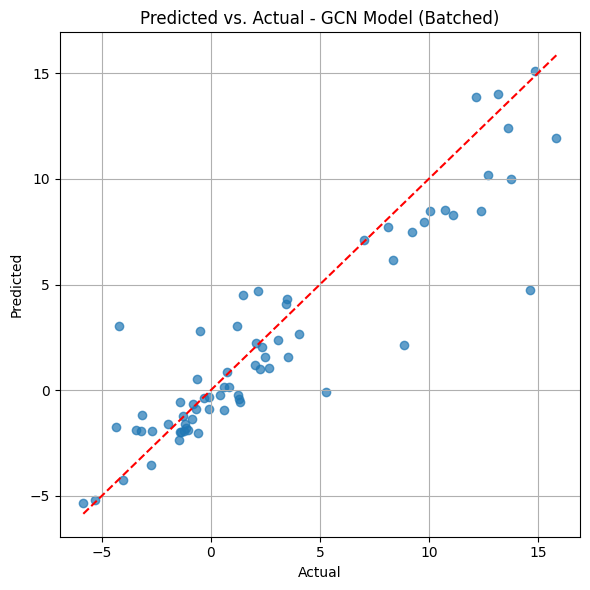

In [16]:
plot_predictions(graph_list, model)

In [17]:
# Create unshuffled evaluation loader so that data labels match the correct graph
eval_loader = DataLoader(graph_list, batch_size=32, shuffle=False)
plot_predictions_plotly(eval_loader, model, metadata_df=molecules_df)

R² score: 0.828
RMSE: 2.351


#### Low Inh Power molecule cluster
- Potassium sodium tartrate
- Oxalic acid
- Tryptamine
- Thiolactic acid
- L-tryptophan
- Nicotinic acid
- 2-picolinic acid
- Sodium lauroylsarcosine
- 1,4-butanediol diglycydyl ether
- Sodium dodecyl benzenesulfonate
- Anthranilic acid
- 3-amino-1,2,4-triazole-5-carboxylic acid
- Isonicotonic acid
- Hexamethylenetetramine
- Salycilic acid
- Calcium D-gluconate monohydrate
- Sodium benzoate


In [81]:
# def visualize_mol(G, color=None, name=None):
#     plt.figure(figsize=(7,7))
#     plt.xticks([])
#     plt.yticks([])
#     if name is not None:
#         plt.title(f"Graph: {name}")
#     nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
#                      node_color=color, cmap="Set2")
#     plt.show()

def visualize_mol(G, name=None, ax=None):
    """
    G: networkx graph
    name: optional title
    ax: matplotlib Axes object
    """
    import matplotlib.pyplot as plt
    import networkx as nx

    if ax is None:
        fig, ax = plt.subplots(figsize=(3,3))

    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_size=50,
        node_color="skyblue",
        edge_color="gray",
        ax=ax
    )
    if name:
        ax.set_title(name, fontsize=8)
    ax.axis("off")


### Low Inhibition Power Molecules

In [82]:
low_pwr_cluster_mols = [
    "Potassium sodium tartrate",
    "Oxalic acid",
    "Tryptamine",
    "Thiolactic acid",
    "L-tryptophan",
    "Nicotinic acid",
    "2-picolinic acid",
    "Sodium lauroylsarcosine",
    "1,4-butanediol diglycydyl ether",
    "Sodium dodecyl benzenesulfonate",
    "Anthranilic acid",
    "3-amino-1,2,4-triazole-5-carboxylic acid",
    "Isonicotonic acid",
    "Hexamethylenetetramine",
    "Salycilic acid",
    "Calcium D-gluconate monohydrate",
    "Sodium benzoate"
]
low_pwr_indices = []
for mol in low_pwr_cluster_mols:
    if mol in molecules_df["Inhibitor Name"].values:
        low_pwr_indices.append(molecules_df[molecules_df["Inhibitor Name"] == mol].index[0])
    else:
        print(f"NOT FOUND: {mol}")
low_pwr_indices

NOT FOUND: 3-amino-1,2,4-triazole-5-carboxylic acid
NOT FOUND: Isonicotonic acid
NOT FOUND: Salycilic acid


[np.int64(49),
 np.int64(47),
 np.int64(68),
 np.int64(64),
 np.int64(44),
 np.int64(46),
 np.int64(17),
 np.int64(58),
 np.int64(6),
 np.int64(57),
 np.int64(30),
 np.int64(41),
 np.int64(36),
 np.int64(55)]

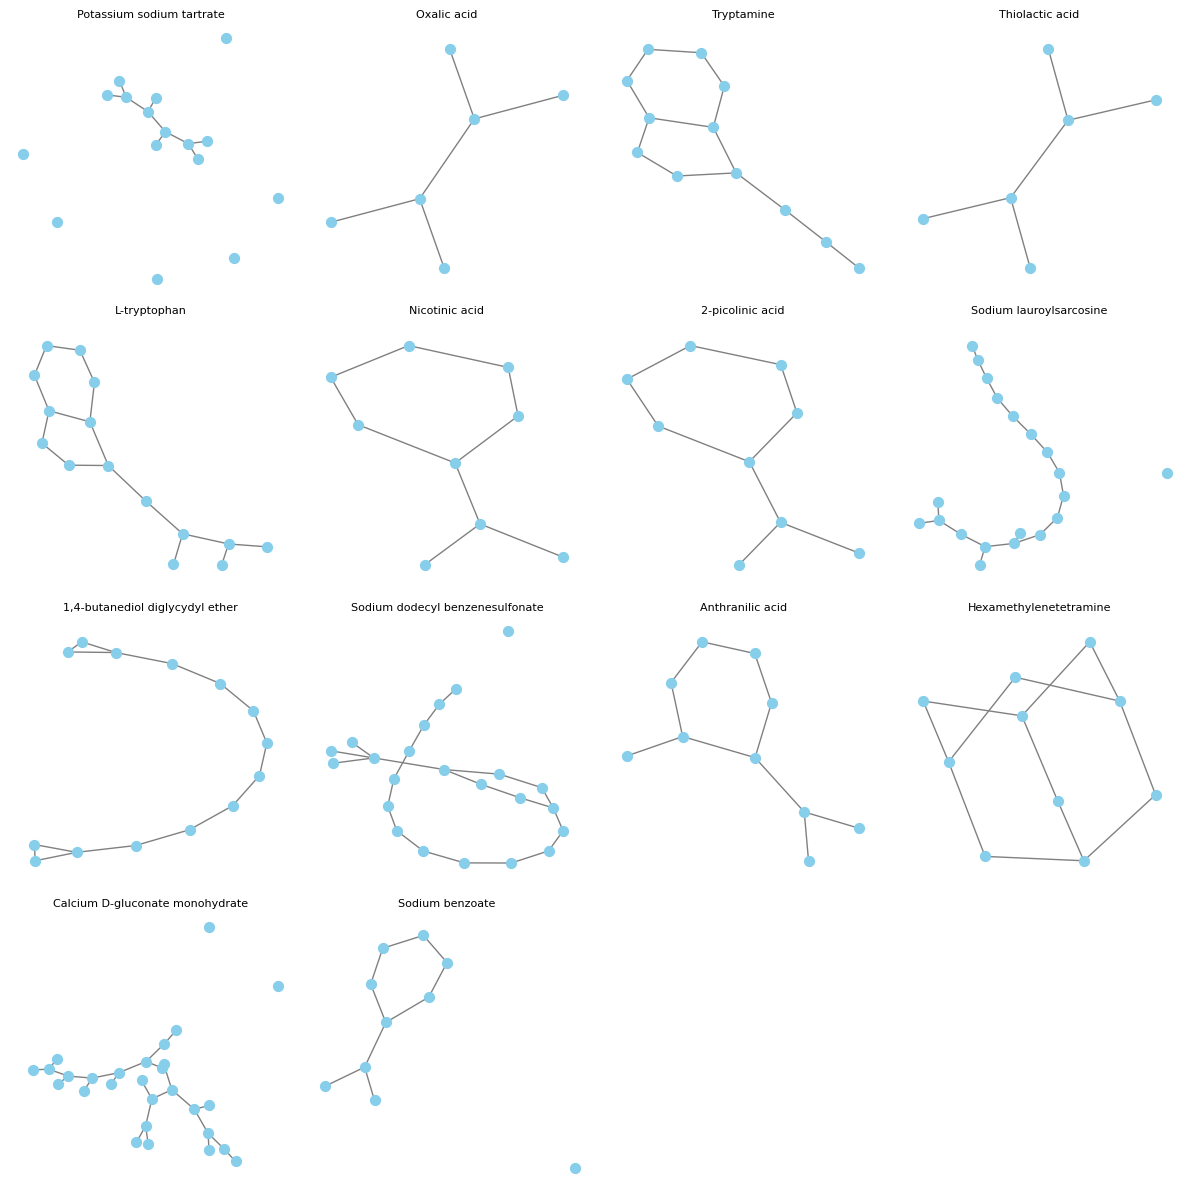

In [88]:
import math
import matplotlib.pyplot as plt

num_mols = len(low_pwr_indices)
cols = 4
rows = math.ceil(num_mols / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

# Flatten in case of single row
axes = axes.flatten()

for i, idx in enumerate(low_pwr_indices):
    G = to_networkx(graph_list[idx], to_undirected=True)
    name = molecules_df["Inhibitor Name"][idx]
    visualize_mol(G, name=name, ax=axes[i])

# Hide unused axes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [89]:
# for idx in low_pwr_indices:
#     graph = graph_list[idx]
#     G = to_networkx(graph, to_undirected=True)
#     visualize_mol(G, name=molecules_df["Inhibitor Name"][idx])

### High Inhibition Power Molecules

In [84]:
high_pwr_cluster_mols = [
    "Benzotriazole",
    "2-mercapto-1-methylimidazole",
    "Sulfathiazole",
    "Ampicilin trihydrate", #Not found in dataset
    "1,3,4-thiadiazole-2,5-dithiol dipotassium salt", #Not found in dataset
    "Dithiooxononamide",
    "1-methyl-1-H-benzimidazole-2-thiol",
    "Sodium thiosalicylate",
    "Sodium diethyldithiocarbomate",
    "2-mercaptobenzothiazole",
    "3-amino-5-mercapto-1,2,4-triazole",
    "Sodium mercaptoacetate",
    "2-mercaptopyridine",
    "2-mercaptopyrimidine",
    "2-mercaptobenzimidazole",
    "Ammonium pyrrolidinedithiocarbamate"
]
high_pwr_indices = []
for mol in high_pwr_cluster_mols:
    if mol in molecules_df["Inhibitor Name"].values:
        high_pwr_indices.append(molecules_df[molecules_df["Inhibitor Name"] == mol].index[0])
    else:
        print(f"NOT FOUND: {mol}")

NOT FOUND: Ampicilin trihydrate
NOT FOUND: Dithiooxononamide


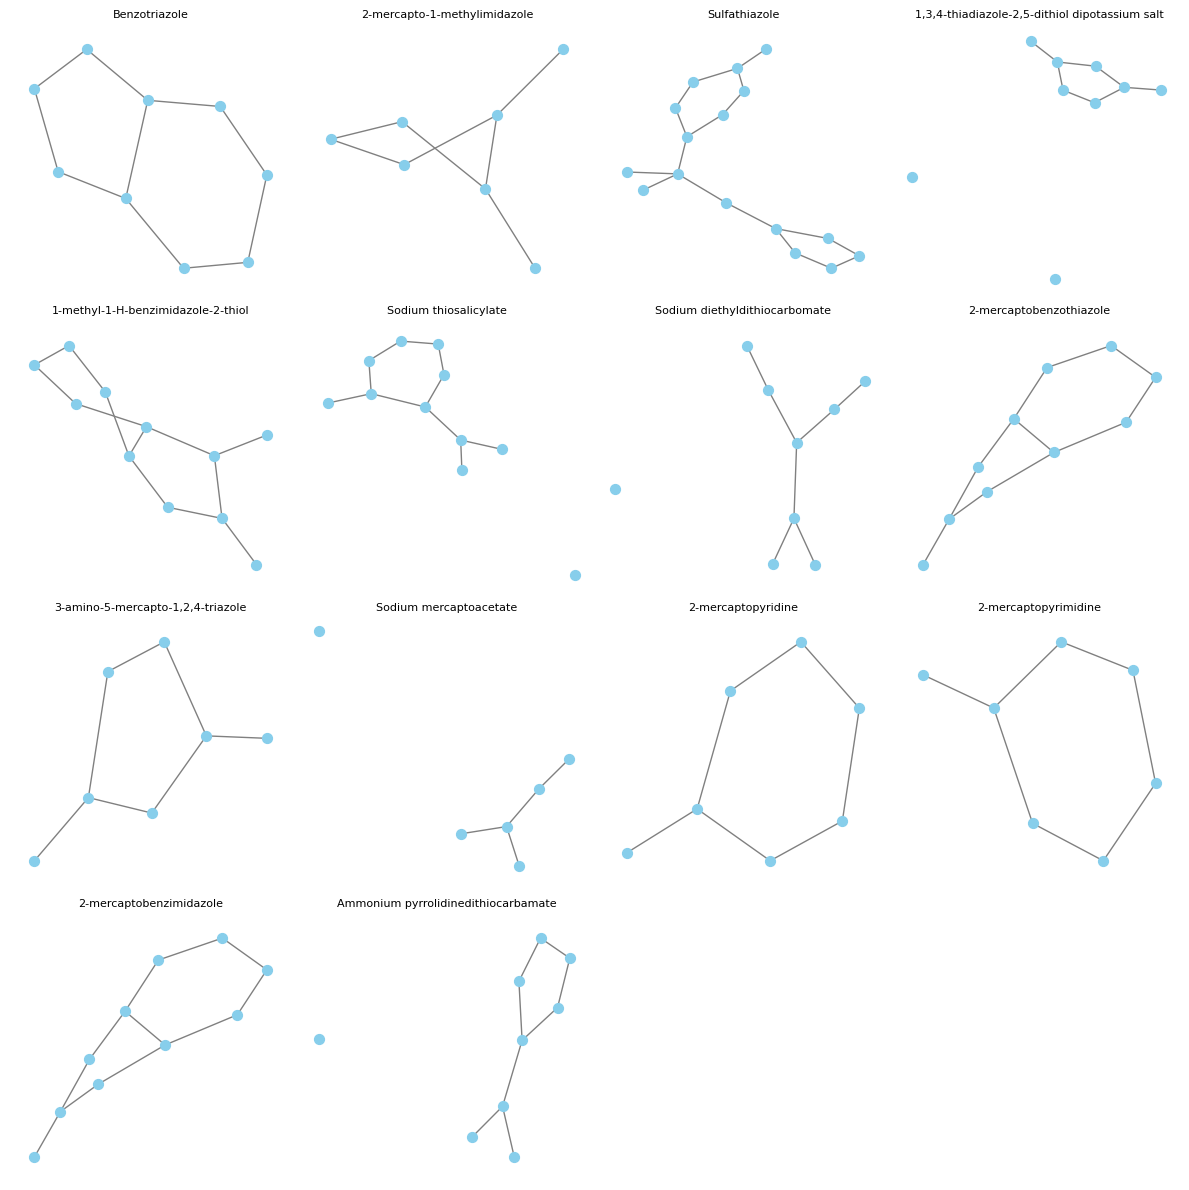

In [85]:
import math
import matplotlib.pyplot as plt

num_mols = len(high_pwr_indices)
cols = 4
rows = math.ceil(num_mols / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

# Flatten in case of single row
axes = axes.flatten()

for i, idx in enumerate(high_pwr_indices):
    G = to_networkx(graph_list[idx], to_undirected=True)
    name = molecules_df["Inhibitor Name"][idx]
    visualize_mol(G, name=name, ax=axes[i])

# Hide unused axes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [87]:
# for idx in high_pwr_indices:
#     graph = graph_list[idx]
#     G = to_networkx(graph, to_undirected=True)
#     visualize_mol(G, name=molecules_df["Inhibitor Name"][idx])

*Note*: ***From a simple view we can see that these molecules that have a high inhibition power, a lot of them have ring structures, OR they are a salt containing sodium.***

## UMAP using Extended Connectivity Fingerprints (ECFPs)

In [28]:
#TODO:[Chiara] From this:
# • Where are the outliers in the GNN pareto plot in this graph? I suppose they’ll be in the trailing bit….
# • What are the common chemical properties in the two clusters? Can you extract the molecule name/SMILE for a couple of molecules in the bottom right and a couple for the top left cluster.

In [29]:
molecules_df.head()

,Inhibitor Name,CAS Number,Inh Power,SMILES
0,1-H-imidazole-2-carboxylic acid,16042-25-4,5.29,C1=CN=C(N1)C(=O)O
1,1-methyl-1-H-benzimidazole-2-thiol,2360-22-7,10.04,CN1C2=CC=CC=C2NC1=S
2,1-methyl-benzimidazole,1632-83-3,-0.51,CN1C=NC2=CC=CC=C21
3,"1,2,4-triazole",288-88-0,2.09,C1=NC=NN1
4,"1,3-diisopropyl-2-thiourea",2986-17-6,3.54,CC(C)NC(=S)NC(C)C


In [30]:
molecules_df.columns

Index(['Inhibitor Name', 'CAS Number', 'Inh Power', 'SMILES'], dtype='object')

In [31]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import numpy as np

# Function to get Morgan fingerprint (ECFP)
def get_ecfp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    arr = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Compute fingerprints for all molecules
ecfps = np.array([get_ecfp(sm) for sm in molecules_df["SMILES"]])
print(ecfps.shape)   # Should be (70, 2048)


(70, 2048)


[16:46:29] DEPRECATION WARNING: please use MorganGenerator
[16:46:29] DEPRECATION WARNING: please use MorganGenerator
[16:46:29] DEPRECATION WARNING: please use MorganGenerator
[16:46:29] DEPRECATION WARNING: please use MorganGenerator
[16:46:29] DEPRECATION WARNING: please use MorganGenerator
[16:46:29] DEPRECATION WARNING: please use MorganGenerator
[16:46:29] DEPRECATION WARNING: please use MorganGenerator
[16:46:29] DEPRECATION WARNING: please use MorganGenerator
[16:46:29] DEPRECATION WARNING: please use MorganGenerator
[16:46:29] DEPRECATION WARNING: please use MorganGenerator
[16:46:29] DEPRECATION WARNING: please use MorganGenerator
[16:46:29] DEPRECATION WARNING: please use MorganGenerator
[16:46:29] DEPRECATION WARNING: please use MorganGenerator
[16:46:29] DEPRECATION WARNING: please use MorganGenerator
[16:46:29] DEPRECATION WARNING: please use MorganGenerator
[16:46:29] DEPRECATION WARNING: please use MorganGenerator
[16:46:29] DEPRECATION WARNING: please use MorganGenerat

In [32]:
import umap

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=123) #, metric="rogerstanimoto")
umap_embeddings = umap_model.fit_transform(ecfps)
print(umap_embeddings.shape)   # (70, 2)


(70, 2)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [33]:
import plotly.express as px
df_umap = molecules_df.copy()
df_umap["UMAP 1"] = umap_embeddings[:,0]
df_umap["UMAP 2"] = umap_embeddings[:,1]


fig = px.scatter(
    df_umap,
    x="UMAP 1",
    y="UMAP 2",
    color="Inh Power",
    hover_data=["Inhibitor Name", "SMILES", "Inh Power"],
    title="UMAP projection of ECFPs colored by Inhibition Power",
    color_continuous_scale=None
)
fig.update_layout(
    width=700,
    height=600
)
fig.show()


## Predicting an arbitrary molcule

In [34]:
def visualize_graph(G, color=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:1438: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



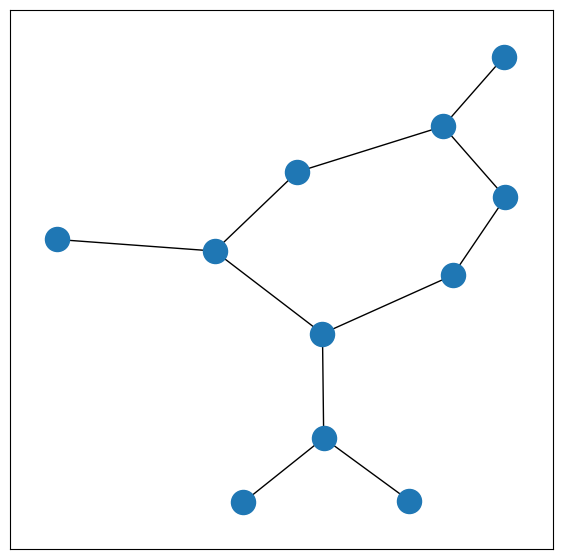

In [35]:
G = to_networkx(graph_list[23], to_undirected=True)
visualize_graph(G)

In [36]:
mol_to_predict = [graph_list[23]]
mol_to_predict[0].y 

tensor([1.2800])

In [37]:
from torch_geometric.data import Batch

def predict_single_molecule(model, molecule_graph):
    model.eval()
    with torch.no_grad():
        batch = Batch.from_data_list([molecule_graph])  # wrap in a list

        prediction = model(
            batch.x, batch.edge_index, batch.batch
        )

        return round(prediction.item(), 4)
predicted_value = predict_single_molecule(model, mol_to_predict[0])
predicted_value

-0.4253

## Effect of Training Parameters on model performance

Here, we will explore the effects of model training parameters (and small model changes) and how these affect model performance. Namely, we will explore the effects of:
* Number of layers used within the model
* Number of epochs used in training
* Learning rate
* Dropout rate


In [38]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch

def r2_rmse(dataloader, model):
    """
    Function to plot predictions vs actual values.
    This function however returns the R² score and RMSE.
    """
    all_preds = [] 
    all_targets = []

    # Put model in evaluation mode
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            preds = model(batch.x, batch.edge_index, batch.batch).squeeze()
            targets = batch.y.squeeze()

            # Handle possible shape mismatches
            if preds.dim() == 0:
                preds = preds.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Compute metrics
    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"R² score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    
    return r2, rmse
    # Plot
    # plt.figure(figsize=(6, 6))
    # plt.scatter(all_targets, all_preds, alpha=0.7)
    # plt.plot([all_targets.min(), all_targets.max()],
    #          [all_targets.min(), all_targets.max()], 'r--')
    # plt.xlabel("Actual")
    # plt.ylabel("Predicted")
    # plt.title("Predicted vs. Actual - GCN Model (Batched)")
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

### Number of layers


#### 1 Layer

In [39]:
metrics_layers = {}

In [40]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNModel1L(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        # GCN layers
        self.conv1 = GCNConv(in_channels, hidden_dim)

        # Feedforward MLP for regression
        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        # batch = torch.zeros(x.size(0), dtype=torch.long)
        x = global_mean_pool(x, batch)
        out = self.ffnn(x)
        return out


In [41]:
model_1L = GCNModel1L(in_channels=num_node_features, hidden_dim=64, out_dim=1)
print(model_1L)

GCNModel1L(
  (conv1): GCNConv(79, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


Epoch 1, Loss: 140.4305
Epoch 2, Loss: 118.0716
Epoch 3, Loss: 138.8486
Epoch 4, Loss: 127.5499
Epoch 5, Loss: 112.1878
Epoch 6, Loss: 135.0060
Epoch 7, Loss: 178.4738
Epoch 8, Loss: 112.2998
Epoch 9, Loss: 125.1164
Epoch 10, Loss: 130.0180
Epoch 11, Loss: 109.0489
Epoch 12, Loss: 138.3692
Epoch 13, Loss: 127.2388
Epoch 14, Loss: 103.1399
Epoch 15, Loss: 121.2005
Epoch 16, Loss: 104.6746
Epoch 17, Loss: 97.9414
Epoch 18, Loss: 96.0295
Epoch 19, Loss: 105.3958
Epoch 20, Loss: 95.6556
Epoch 21, Loss: 90.6050
Epoch 22, Loss: 81.8459
Epoch 23, Loss: 80.0878
Epoch 24, Loss: 84.7471
Epoch 25, Loss: 103.6050
Epoch 26, Loss: 102.0124
Epoch 27, Loss: 88.8386
Epoch 28, Loss: 96.6255
Epoch 29, Loss: 101.2180
Epoch 30, Loss: 104.4015
Epoch 31, Loss: 77.1599
Epoch 32, Loss: 76.8912
Epoch 33, Loss: 78.9028
Epoch 34, Loss: 104.2290
Epoch 35, Loss: 102.4165
Epoch 36, Loss: 78.0078
Epoch 37, Loss: 91.8543
Epoch 38, Loss: 92.5310
Epoch 39, Loss: 79.8562
Epoch 40, Loss: 115.3499
Epoch 41, Loss: 81.7091
E

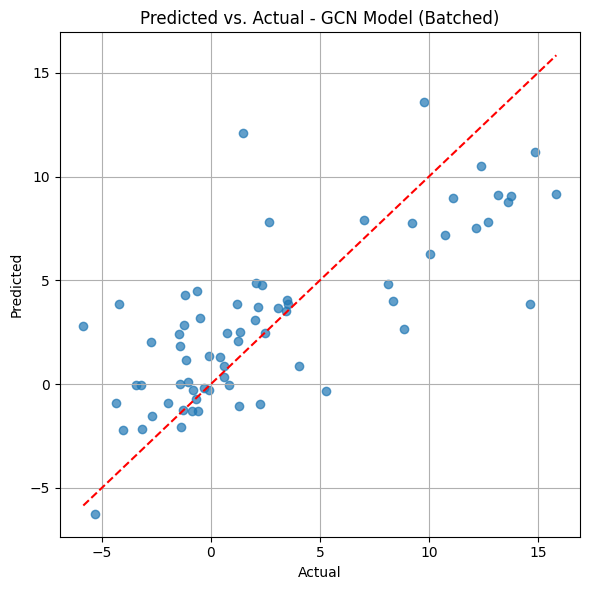

R² score: 0.573
RMSE: 3.700


In [42]:
train_gcn_model_batched(train_loader, model_1L, lr=1e-3, epochs=300)
plot_predictions(train_loader, model_1L)
metrics_layers['1L'] = r2_rmse(train_loader, model_1L)

#### 2 Layers

In [43]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNModel2L(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        # GCN layers
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)


        # Feedforward MLP for regression
        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # batch = torch.zeros(x.size(0), dtype=torch.long)
        x = global_mean_pool(x, batch)
        out = self.ffnn(x)
        return out


In [44]:
model_2L = GCNModel2L(in_channels=num_node_features, hidden_dim=64, out_dim=1)
print(model_2L)

GCNModel2L(
  (conv1): GCNConv(79, 64)
  (conv2): GCNConv(64, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


Epoch 1, Loss: 101.7409
Epoch 2, Loss: 134.7323
Epoch 3, Loss: 134.8243
Epoch 4, Loss: 128.4420
Epoch 5, Loss: 109.9873
Epoch 6, Loss: 120.9565
Epoch 7, Loss: 116.1724
Epoch 8, Loss: 89.9889
Epoch 9, Loss: 81.5805
Epoch 10, Loss: 126.1223
Epoch 11, Loss: 122.5735
Epoch 12, Loss: 80.9343
Epoch 13, Loss: 106.0363
Epoch 14, Loss: 88.8910
Epoch 15, Loss: 91.8711
Epoch 16, Loss: 97.0950
Epoch 17, Loss: 76.6871
Epoch 18, Loss: 104.4603
Epoch 19, Loss: 76.8146
Epoch 20, Loss: 110.4025
Epoch 21, Loss: 81.6074
Epoch 22, Loss: 77.9312
Epoch 23, Loss: 101.7195
Epoch 24, Loss: 82.7513
Epoch 25, Loss: 80.4541
Epoch 26, Loss: 84.0169
Epoch 27, Loss: 104.9634
Epoch 28, Loss: 77.3561
Epoch 29, Loss: 95.5257
Epoch 30, Loss: 93.1560
Epoch 31, Loss: 88.8348
Epoch 32, Loss: 107.9911
Epoch 33, Loss: 82.1725
Epoch 34, Loss: 74.3923
Epoch 35, Loss: 108.7844
Epoch 36, Loss: 88.8780
Epoch 37, Loss: 78.5706
Epoch 38, Loss: 74.5608
Epoch 39, Loss: 74.1303
Epoch 40, Loss: 88.1754
Epoch 41, Loss: 90.2586
Epoch 42,

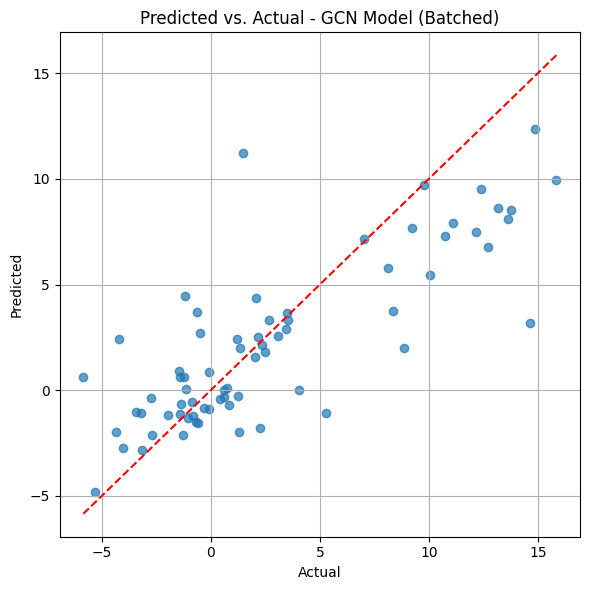

R² score: 0.634
RMSE: 3.424


In [45]:
train_gcn_model_batched(train_loader, model_2L, lr=1e-3, epochs=300)
plot_predictions(train_loader, model_2L)
metrics_layers['2L'] = r2_rmse(train_loader, model_2L)


#### 3 Layers

In [46]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNModel3L(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        # GCN layers
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)

        # Feedforward MLP for regression
        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        x = self.conv3(x, edge_index)
        x = torch.relu(x)

        # batch = torch.zeros(x.size(0), dtype=torch.long)
        x = global_mean_pool(x, batch)
        out = self.ffnn(x)
        return out


In [47]:
model_3L = GCNModel3L(in_channels=num_node_features, hidden_dim=64, out_dim=1)
print(model_3L)

GCNModel3L(
  (conv1): GCNConv(79, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [48]:
train_gcn_model_batched(train_loader, model_3L, epochs=300, lr=1e-3)

Epoch 1, Loss: 158.3328
Epoch 2, Loss: 130.9716
Epoch 3, Loss: 120.6368
Epoch 4, Loss: 121.9351
Epoch 5, Loss: 111.7320
Epoch 6, Loss: 94.8550
Epoch 7, Loss: 133.6578
Epoch 8, Loss: 84.8347
Epoch 9, Loss: 106.1087
Epoch 10, Loss: 101.5475
Epoch 11, Loss: 98.7149
Epoch 12, Loss: 84.0089
Epoch 13, Loss: 112.6891
Epoch 14, Loss: 101.4728
Epoch 15, Loss: 92.2156
Epoch 16, Loss: 84.1307
Epoch 17, Loss: 115.3706
Epoch 18, Loss: 95.3568
Epoch 19, Loss: 71.1571
Epoch 20, Loss: 84.3010
Epoch 21, Loss: 79.2738
Epoch 22, Loss: 95.1812
Epoch 23, Loss: 78.7834
Epoch 24, Loss: 82.7118
Epoch 25, Loss: 90.6186
Epoch 26, Loss: 88.8301
Epoch 27, Loss: 66.2485
Epoch 28, Loss: 97.2478
Epoch 29, Loss: 75.1553
Epoch 30, Loss: 83.4582
Epoch 31, Loss: 87.6408
Epoch 32, Loss: 75.5735
Epoch 33, Loss: 72.1024
Epoch 34, Loss: 84.2346
Epoch 35, Loss: 75.5745
Epoch 36, Loss: 67.6936
Epoch 37, Loss: 76.4156
Epoch 38, Loss: 77.2248
Epoch 39, Loss: 75.6606
Epoch 40, Loss: 83.3331
Epoch 41, Loss: 69.4319
Epoch 42, Loss

GCNModel3L(
  (conv1): GCNConv(79, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

R² score: 0.684
RMSE: 3.181


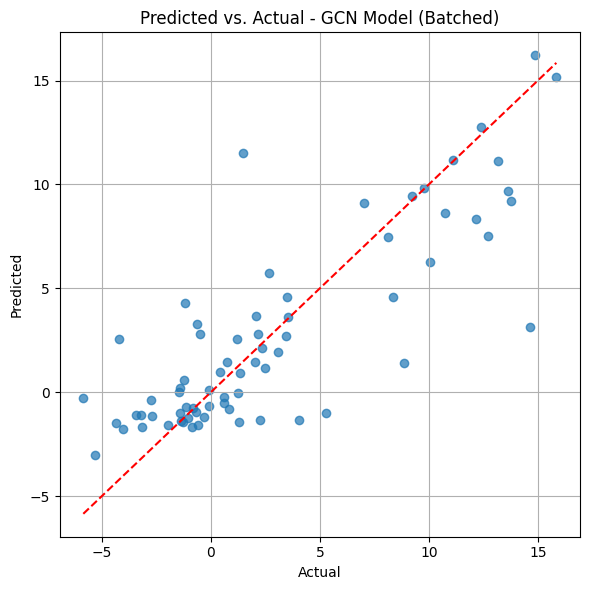

R² score: 0.684
RMSE: 3.181


In [49]:
plot_predictions(train_loader, model_3L)
metrics_layers['3L'] = r2_rmse(train_loader, model_3L)

In [50]:
metrics_layers

{'1L': (0.5731279850006104, np.float64(3.699700554767411)),
 '2L': (0.6343485116958618, np.float64(3.424138961931194)),
 '3L': (0.6844356060028076, np.float64(3.1809857691542747))}

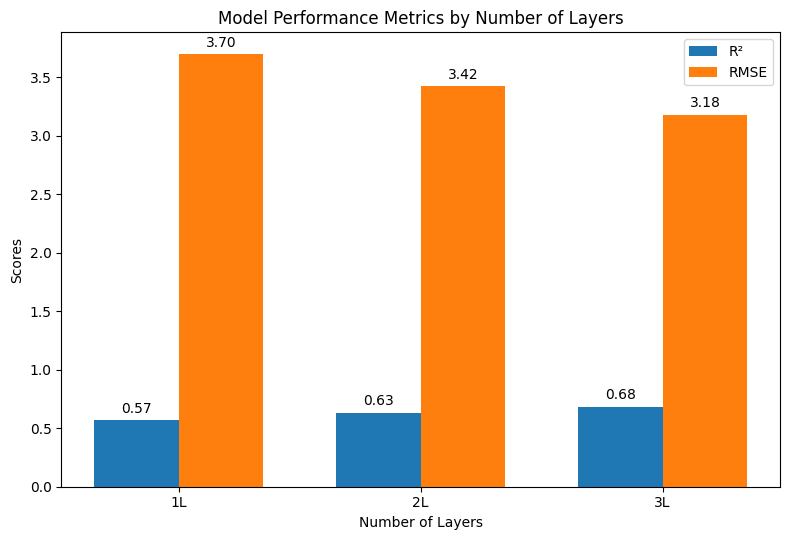

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(metrics_layers.keys())
r2_scores = [v[0] for v in metrics_layers.values()]
rmse_scores = [v[1] for v in metrics_layers.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Number of Layers')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics by Number of Layers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


### Number of Epochs

In [51]:
epochs = [100, 200, 300, 400, 500]
metrics_epoch = {}
for epoch in [100, 200, 300, 400, 500]:
    model3 = GCNModel(in_channels=num_node_features, hidden_dim=64, out_dim=1)
    train_gcn_model_batched(train_loader, model3, epochs=epoch, lr=1e-3)
    metrics_epoch[epoch] = r2_rmse(train_loader, model3)
metrics_epoch

Epoch 1, Loss: 140.1912
Epoch 2, Loss: 115.8955
Epoch 3, Loss: 111.9480
Epoch 4, Loss: 104.5641
Epoch 5, Loss: 88.5128
Epoch 6, Loss: 89.5679
Epoch 7, Loss: 109.3101
Epoch 8, Loss: 92.1815
Epoch 9, Loss: 103.1025
Epoch 10, Loss: 88.9287
Epoch 11, Loss: 118.8828
Epoch 12, Loss: 124.5932
Epoch 13, Loss: 83.6125
Epoch 14, Loss: 109.9446
Epoch 15, Loss: 116.9306
Epoch 16, Loss: 113.8256
Epoch 17, Loss: 117.7165
Epoch 18, Loss: 90.6324
Epoch 19, Loss: 100.9860
Epoch 20, Loss: 102.4328
Epoch 21, Loss: 84.4440
Epoch 22, Loss: 96.4691
Epoch 23, Loss: 103.1517
Epoch 24, Loss: 92.6014
Epoch 25, Loss: 75.8533
Epoch 26, Loss: 86.9006
Epoch 27, Loss: 78.9175
Epoch 28, Loss: 102.8300
Epoch 29, Loss: 99.9977
Epoch 30, Loss: 94.1741
Epoch 31, Loss: 100.4243
Epoch 32, Loss: 91.0405
Epoch 33, Loss: 83.3484
Epoch 34, Loss: 109.1553
Epoch 35, Loss: 111.5361
Epoch 36, Loss: 84.6218
Epoch 37, Loss: 78.0231
Epoch 38, Loss: 84.5447
Epoch 39, Loss: 89.1682
Epoch 40, Loss: 93.5960
Epoch 41, Loss: 82.2517
Epoch 

{100: (0.3518058657646179, np.float64(4.559007117612069)),
 200: (0.48479634523391724, np.float64(4.064500521558103)),
 300: (0.5712589025497437, np.float64(3.70779112091524)),
 400: (0.5883615016937256, np.float64(3.6330861634574476)),
 500: (0.6459041833877563, np.float64(3.3695983045111846))}

In [52]:
for key, value in metrics_epoch.items():
    print(f"Epochs: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Epochs: 100, R²: 0.352, RMSE: 4.559
Epochs: 200, R²: 0.485, RMSE: 4.065
Epochs: 300, R²: 0.571, RMSE: 3.708
Epochs: 400, R²: 0.588, RMSE: 3.633
Epochs: 500, R²: 0.646, RMSE: 3.370


In [53]:
graph_list[0].y

tensor([5.2900])

In [54]:
# Exploreing the variance of all Inhibition POwer values in the dataset as a possible source of error
targets = []
for graph in graph_list:
    targets.append(graph.y.item())
np.var(targets)

np.float64(32.06530972525442)

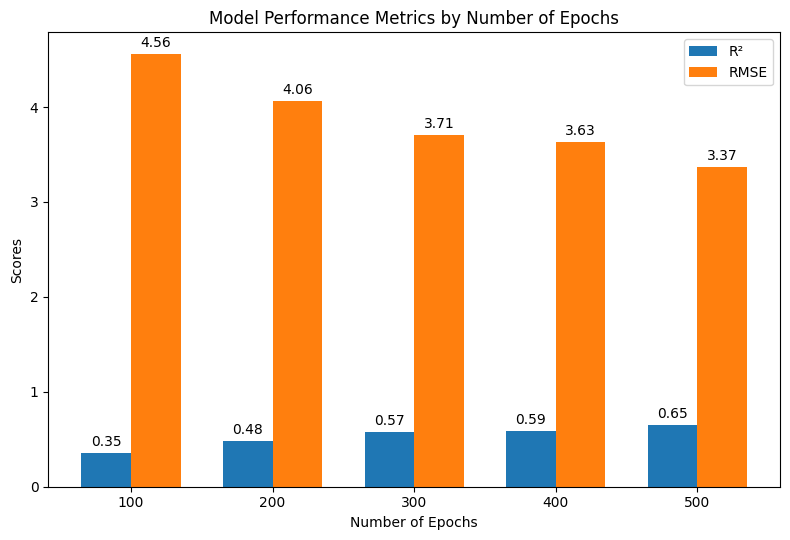

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(metrics_epoch.keys())
r2_scores = [v[0] for v in metrics_epoch.values()]
rmse_scores = [v[1] for v in metrics_epoch.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics by Number of Epochs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


### Learning rate

In [55]:
lrs = [1e-1 ,1e-2 ,1e-3, 1e-4, 1e-5, 1e-6]
obsv_lr_metrics = {}

for lr in lrs:
    model_e3 = GCNModel(in_channels=num_node_features, hidden_dim=64, out_dim=1)
    train_gcn_model_batched(train_loader, model_e3, epochs=300, lr=lr)
    obsv_lr_metrics[lr] = r2_rmse(train_loader, model_e3)
    print(f"Learning Rate: {lr}, R²: {obsv_lr_metrics[lr][0]:.3f}, RMSE: {obsv_lr_metrics[lr][1]:.3f}")

Epoch 1, Loss: 200.3243
Epoch 2, Loss: 127.8092
Epoch 3, Loss: 102.3201
Epoch 4, Loss: 129.0632
Epoch 5, Loss: 111.8878
Epoch 6, Loss: 102.7039
Epoch 7, Loss: 97.8576
Epoch 8, Loss: 95.8301
Epoch 9, Loss: 107.4515
Epoch 10, Loss: 116.8360
Epoch 11, Loss: 125.5524
Epoch 12, Loss: 105.7763
Epoch 13, Loss: 108.6463
Epoch 14, Loss: 83.9182
Epoch 15, Loss: 85.1929
Epoch 16, Loss: 83.4683
Epoch 17, Loss: 93.5510
Epoch 18, Loss: 119.4879
Epoch 19, Loss: 91.5718
Epoch 20, Loss: 75.8894
Epoch 21, Loss: 93.6680
Epoch 22, Loss: 93.0843
Epoch 23, Loss: 98.7031
Epoch 24, Loss: 109.7800
Epoch 25, Loss: 81.3747
Epoch 26, Loss: 76.8601
Epoch 27, Loss: 90.8998
Epoch 28, Loss: 116.5666
Epoch 29, Loss: 99.9040
Epoch 30, Loss: 81.0172
Epoch 31, Loss: 91.4959
Epoch 32, Loss: 117.8271
Epoch 33, Loss: 105.5685
Epoch 34, Loss: 119.7906
Epoch 35, Loss: 86.5662
Epoch 36, Loss: 81.5581
Epoch 37, Loss: 104.2286
Epoch 38, Loss: 99.2908
Epoch 39, Loss: 85.6491
Epoch 40, Loss: 85.9663
Epoch 41, Loss: 88.7145
Epoch 4

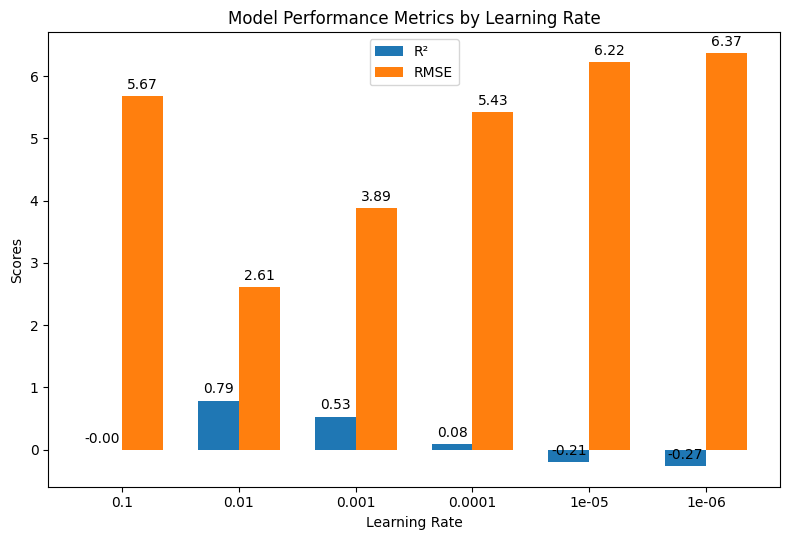

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(obsv_lr_metrics.keys())
r2_scores = [v[0] for v in obsv_lr_metrics.values()]
rmse_scores = [v[1] for v in obsv_lr_metrics.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics by Learning Rate')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


### Dropout Rate

In [57]:
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
obsv_dropout_metrics = {}

for dr in dropout_rates:
    model_dr = GCNModel(in_channels=num_node_features, hidden_dim=64, out_dim=1, dropout_rate=dr)
    train_gcn_model_batched(train_loader, model_dr, epochs=300, lr=1e-3)
    obsv_dropout_metrics[dr] = r2_rmse(train_loader, model_dr)


Epoch 1, Loss: 88.0110
Epoch 2, Loss: 93.0156
Epoch 3, Loss: 133.2314
Epoch 4, Loss: 104.0720
Epoch 5, Loss: 102.0767
Epoch 6, Loss: 112.1445
Epoch 7, Loss: 196.0378
Epoch 8, Loss: 103.0360
Epoch 9, Loss: 130.3675
Epoch 10, Loss: 115.1352
Epoch 11, Loss: 98.7085
Epoch 12, Loss: 102.9246
Epoch 13, Loss: 81.1375
Epoch 14, Loss: 89.5522
Epoch 15, Loss: 98.1458
Epoch 16, Loss: 93.7745
Epoch 17, Loss: 78.9077
Epoch 18, Loss: 87.5729
Epoch 19, Loss: 88.5629
Epoch 20, Loss: 78.7848
Epoch 21, Loss: 90.7207
Epoch 22, Loss: 107.9523
Epoch 23, Loss: 81.1547
Epoch 24, Loss: 124.2359
Epoch 25, Loss: 106.7182
Epoch 26, Loss: 100.5950
Epoch 27, Loss: 74.8014
Epoch 28, Loss: 95.9619
Epoch 29, Loss: 103.1748
Epoch 30, Loss: 95.9237
Epoch 31, Loss: 82.4443
Epoch 32, Loss: 102.8420
Epoch 33, Loss: 82.0840
Epoch 34, Loss: 89.6202
Epoch 35, Loss: 85.1350
Epoch 36, Loss: 104.7597
Epoch 37, Loss: 92.4233
Epoch 38, Loss: 98.8217
Epoch 39, Loss: 89.8165
Epoch 40, Loss: 88.3183
Epoch 41, Loss: 72.8525
Epoch 42,

In [58]:
obsv_dropout_metrics

{0.1: (0.5683764219284058, np.float64(3.720234422373094)),
 0.2: (0.5574654936790466, np.float64(3.7669623441745737)),
 0.3: (0.5461684465408325, np.float64(3.814740882563144)),
 0.4: (0.5180926322937012, np.float64(3.9309681801994065)),
 0.5: (0.5214825868606567, np.float64(3.91711769483076))}

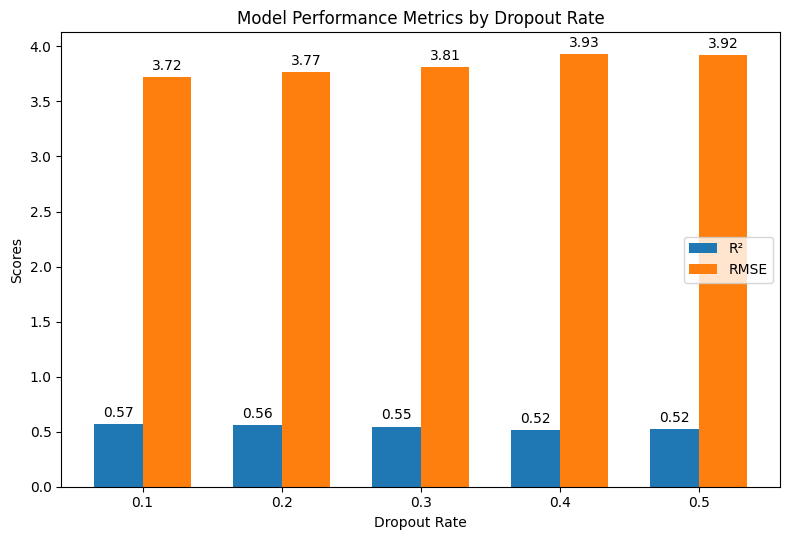

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(obsv_dropout_metrics.keys())
r2_scores = [v[0] for v in obsv_dropout_metrics.values()]
rmse_scores = [v[1] for v in obsv_dropout_metrics.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Dropout Rate')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics by Dropout Rate')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


## Investigating model inconsistency due to batching



In [59]:
from torch.nn import MSELoss
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch

# TODO:
batch = Batch.from_data_list(graph_list)
in_channels = batch.x.size(1)
# train_loader = DataLoader(graph_list, batch_size=32, shuffle=True)


def train_gcn_fullbatch(batch, model, lr=1e-3, epochs=300):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = MSELoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch).squeeze()
        target = batch.y.squeeze()

        assert out.shape == target.shape, f"{out.shape=} vs {target.shape=}"
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    
    return model



In [60]:
batches = [1, 2, 4,8, 16, 32, 64, 70]
metrics_batches = {}
for batch_size in batches:
    train_loader = DataLoader(graph_list, batch_size=batch_size, shuffle=True)
    model_b = GCNModel(in_channels=in_channels, hidden_dim=64, out_dim=1)
    print(f"Training with batch size: {batch_size}")
    train_gcn_model_batched(train_loader, model_b, lr=1e-3, epochs=300)
    # plot_predictions(train_loader, model_b)
    metrics_batches[batch_size] = r2_rmse(train_loader, model_b)



Training with batch size: 1
Epoch 1, Loss: 2694.7779
Epoch 2, Loss: 2427.3148
Epoch 3, Loss: 2287.2765
Epoch 4, Loss: 2215.9900
Epoch 5, Loss: 2194.4088
Epoch 6, Loss: 2096.3055
Epoch 7, Loss: 2103.0832
Epoch 8, Loss: 2136.9284
Epoch 9, Loss: 2071.9289
Epoch 10, Loss: 1946.3782
Epoch 11, Loss: 1844.4801
Epoch 12, Loss: 1863.7512
Epoch 13, Loss: 1754.1287
Epoch 14, Loss: 1702.1426
Epoch 15, Loss: 1590.5880
Epoch 16, Loss: 1728.3466
Epoch 17, Loss: 1476.5721
Epoch 18, Loss: 1502.0298
Epoch 19, Loss: 1532.7720
Epoch 20, Loss: 1522.5967
Epoch 21, Loss: 1348.9514
Epoch 22, Loss: 1454.7147
Epoch 23, Loss: 1379.4060
Epoch 24, Loss: 1432.5877
Epoch 25, Loss: 1320.9538
Epoch 26, Loss: 1550.9754
Epoch 27, Loss: 1327.3868
Epoch 28, Loss: 1374.8077
Epoch 29, Loss: 1342.5230
Epoch 30, Loss: 1364.6863
Epoch 31, Loss: 1378.6855
Epoch 32, Loss: 1372.4209
Epoch 33, Loss: 1362.4591
Epoch 34, Loss: 1372.4264
Epoch 35, Loss: 1154.0871
Epoch 36, Loss: 1394.8363
Epoch 37, Loss: 1333.5598
Epoch 38, Loss: 120

In [61]:
for key, value in metrics_batches.items():
    print(f"Batch Size: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Batch Size: 1, R²: 0.796, RMSE: 2.559
Batch Size: 2, R²: 0.750, RMSE: 2.833
Batch Size: 4, R²: 0.680, RMSE: 3.204
Batch Size: 8, R²: 0.659, RMSE: 3.306
Batch Size: 16, R²: 0.628, RMSE: 3.453
Batch Size: 32, R²: 0.536, RMSE: 3.859
Batch Size: 64, R²: 0.491, RMSE: 4.042
Batch Size: 70, R²: 0.556, RMSE: 3.774


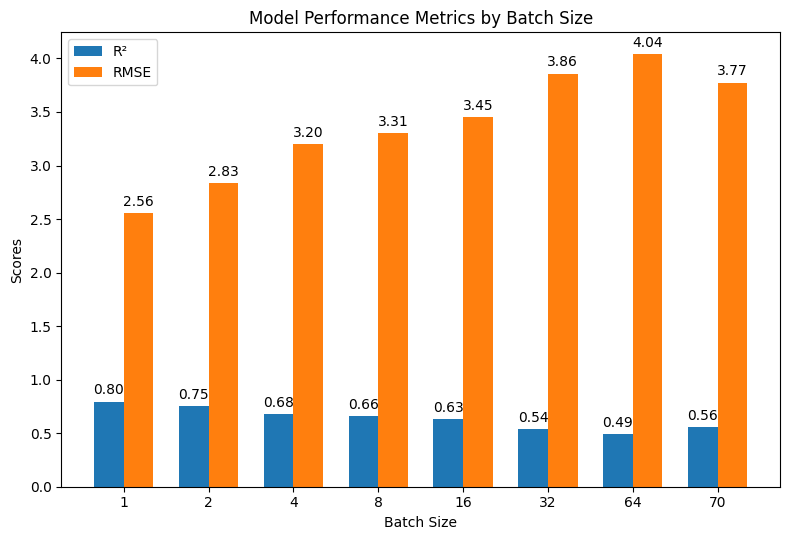

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(metrics_batches.keys())
r2_scores = [v[0] for v in metrics_batches.values()]
rmse_scores = [v[1] for v in metrics_batches.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Batch Size')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics by Batch Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


GCNModel(
  (conv1): GCNConv(79, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch 1, Loss: 40.8063
Epoch 2, Loss: 40.7404
Epoch 3, Loss: 40.4959
Epoch 4, Loss: 40.2560
Epoch 5, Loss: 40.0841
Epoch 6, Loss: 39.9859
Epoch 7, Loss: 39.7896
Epoch 8, Loss: 39.6023
Epoch 9, Loss: 39.4379
Epoch 10, Loss: 39.2317
Epoch 11, Loss: 39.0274
Epoch 12, Loss: 38.9911
Epoch 13, Loss: 38.7814
Epoch 14, Loss: 38.5666
Epoch 15, Loss: 38.5006
Epoch 16, Loss: 38.3084
Epoch 17, Loss: 38.0936
Epoch 18, Loss: 37.9108
Epoch 19, Loss: 37.7318
Epoch 20, Loss: 37.5302
Epoch 21, Loss: 37.1654
Epoch 22, Loss: 37.2225
Epoch 23, Loss: 36.6334
Epoch 24, Loss: 36.6930
Epoch 25, Loss: 36.5236
Epoch 26, Loss: 36.0237
Epoch 27, Loss: 35.8575
Epoch 28, Loss: 35.6981
Epoch 29, Loss: 35.1439
Epoch 30, Loss: 34.8551
Epoch 31, Loss: 34.6943
Epoch 32, Loss: 34.7796
Ep

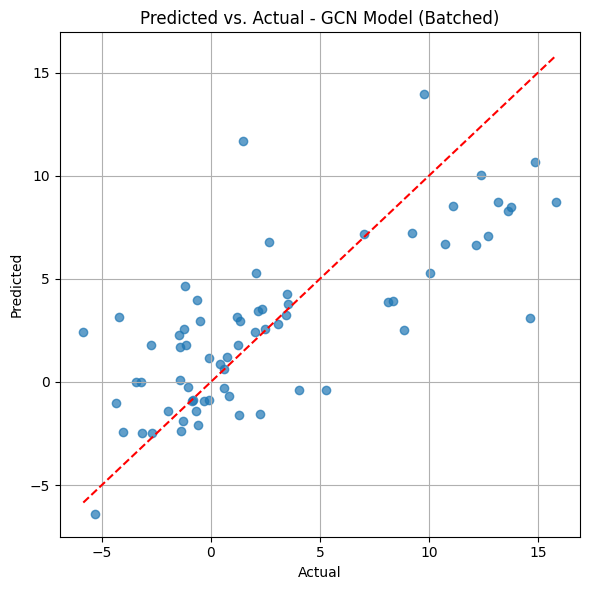

AttributeError: 'tuple' object has no attribute 'x'

In [62]:
model_b = GCNModel(in_channels=in_channels, hidden_dim=64, out_dim=1)
print(model_b)

train_gcn_fullbatch(batch, model_b, lr=1e-3, epochs=300)
plot_predictions(graph_list, model_b)
metrics_batches['Batch'] = r2_rmse(batch, model_b)
# Need to change plot predictions function to handle full batch